In [43]:
%%HTML
<style>
    body {
        --vscode-font-family: "JetBrains Mono";
    }
</style>

## 1 - Importing Libraries

In [44]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

import joblib

## 2 - Read Dataset

In [45]:
# read data from csv
heart_path = "./heart.csv"
df = pd.read_csv(heart_path)

In [46]:
# shows dataset
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Data set descriptions:

| Variable | Description |
|----------|-------------|
| age | Age of the patient in years |
| sex | Gender of the patient (0 = male, 1 = female) |
| cp | Chest pain type: <br/> 0: Typical angina <br/> 1: Atypical angina <br/> 2: Non-anginal pain <br/> 3: Asymptomatic
| trestbps | Resting blood pressure in mm Hg |
| chol | Serum cholesterol in mg/dl |
| fbs | Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false) |
| restecg | Resting elactrocardiographic results: <br/> 0: Normal <br/> 1: Having ST-T abnormality <br/> 2: Showing probable of definite left venticular hyperthrophy |
| thalach | Maximum heart rate achieved during a stress test |
| exang | Excercie-indused angina (1 = yes, 0 = no) |
| oldpeak | ST depression induced by excersice relative to test |
| slope | Slope of the peak excersie ST segment: <br/> 0: Upsloping <br/> 1: Flat <br/> 2: Downsloping |
| ca | Number of major vessels (0-4) colored by flouroscopy |
| thal | Thalium stress test result: <br/> 0: Normal <br/> 1: Fixed defect <br/> 2: Reversible defect <br/> 3: Not described |
| target | Heart disease status (0 = no disease, 1 = presedence of disease)

## 3 - Dataset Overview

### 3.1 Dataset Basic Overview

In [47]:
# database overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


- Number of Entries: The dataset consists of 303 entries, ranging from index 0 to 302.
- Columns: There are 14 columns in the dataset corresponding to various attributes of the patients and results of tests.
- Data Types:
    - Most of the columns (13 out of 14) are of the int64 data type.
    - Only the oldpeak column is of the float64 data type.
- Missing Values: There don't appear to be any missing values in the dataset as each column has 303 non-null entries.

> Note: <br/> Based on the data types and the feature explanations we had earlier, we can see that 9 columns (sex, cp, fbs, restecg, exang, slope, ca, thal, and target) are indeed numerical in terms of data type, but categorical in terms of their semantics. These features should be converted to string (object) data type for proper analysis and interpretation:

In [48]:
# define the continuous features
continuous_fetures = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_fetures]

# convert the identified features to object data types
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

### 3.2 Dataset Statistics for Numerical Variables

In [49]:
df.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


Numerical Features:
  - age: The average age of the patients is approximately 54.4 years, with the youngest being 29 and the oldest 77 years.
  - trestbps: The average resting blood pressure is about 131.62 mm Hg, ranging from 94 to 200 mm Hg.
  - chol: The average cholesterol level is approximately 246.26 mg/dl, with a minimum of 126 and a maximum of 564 mg/dl.
  - thalach: The average maximum heart rate achieved is around 149.65, with a range from 71 to 202.
  - oldpeak: The average ST depression induced by exercise relative to rest is about 1.04, with values ranging from 0 to 6.2.

### 3.3 Summary Statistics for Categorical Variable

In [50]:
# get summary statistics for categorical variables
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


Categorical Features (object data type):
- sex: There are two unique values, with females (denoted as 1) being the most frequent category, occurring 207 times out of 303 entries.
- cp: Four unique types of chest pain are present. The most common type is "0", occurring 143 times.
- fbs: There are two categories, and the most frequent one is "0" (indicating fasting blood sugar less than 120 mg/dl), which appears 258 times.
- restecg: Three unique results are present. The most common result is "1", appearing 152 times.
- exang: There are two unique values. The most frequent value is "0" (indicating no exercise-induced angina), which is observed 204 times.
- slope: Three unique slopes are present. The most frequent slope type is "2", which occurs 142 times.
- ca: There are five unique values for the number of major vessels colored by fluoroscopy, with "0" being the most frequent, occurring 175 times.
- thal: Four unique results are available. The most common type is "2" (indicating a reversible defect), observed 166 times.
- target: Two unique values indicate the presence or absence of heart disease. The value "1" (indicating the presence of heart disease) is the most frequent, observed in 165 entries.

## 4 - Exploratory Data Analysis

### 4.1 Univariate Analysis

We undertake univariate analysis on the dataset's features, based on their datatype:
- For continuous data: We employ histograms to gain insight into the distribution of each feature. This allows us to understand the central tendency, spread, and shape of the dataset's distribution.
- For categorical data: Bar plots are utilized to visualize the frequency of each category. This provides a clear representation of the prominence of each category within the respective feature.

By employing these visualization techniques, we're better positioned to understand the individual characteristics of each feature in the dataset.

##### 4.1.1 Numerical Variables Univariate Analysis

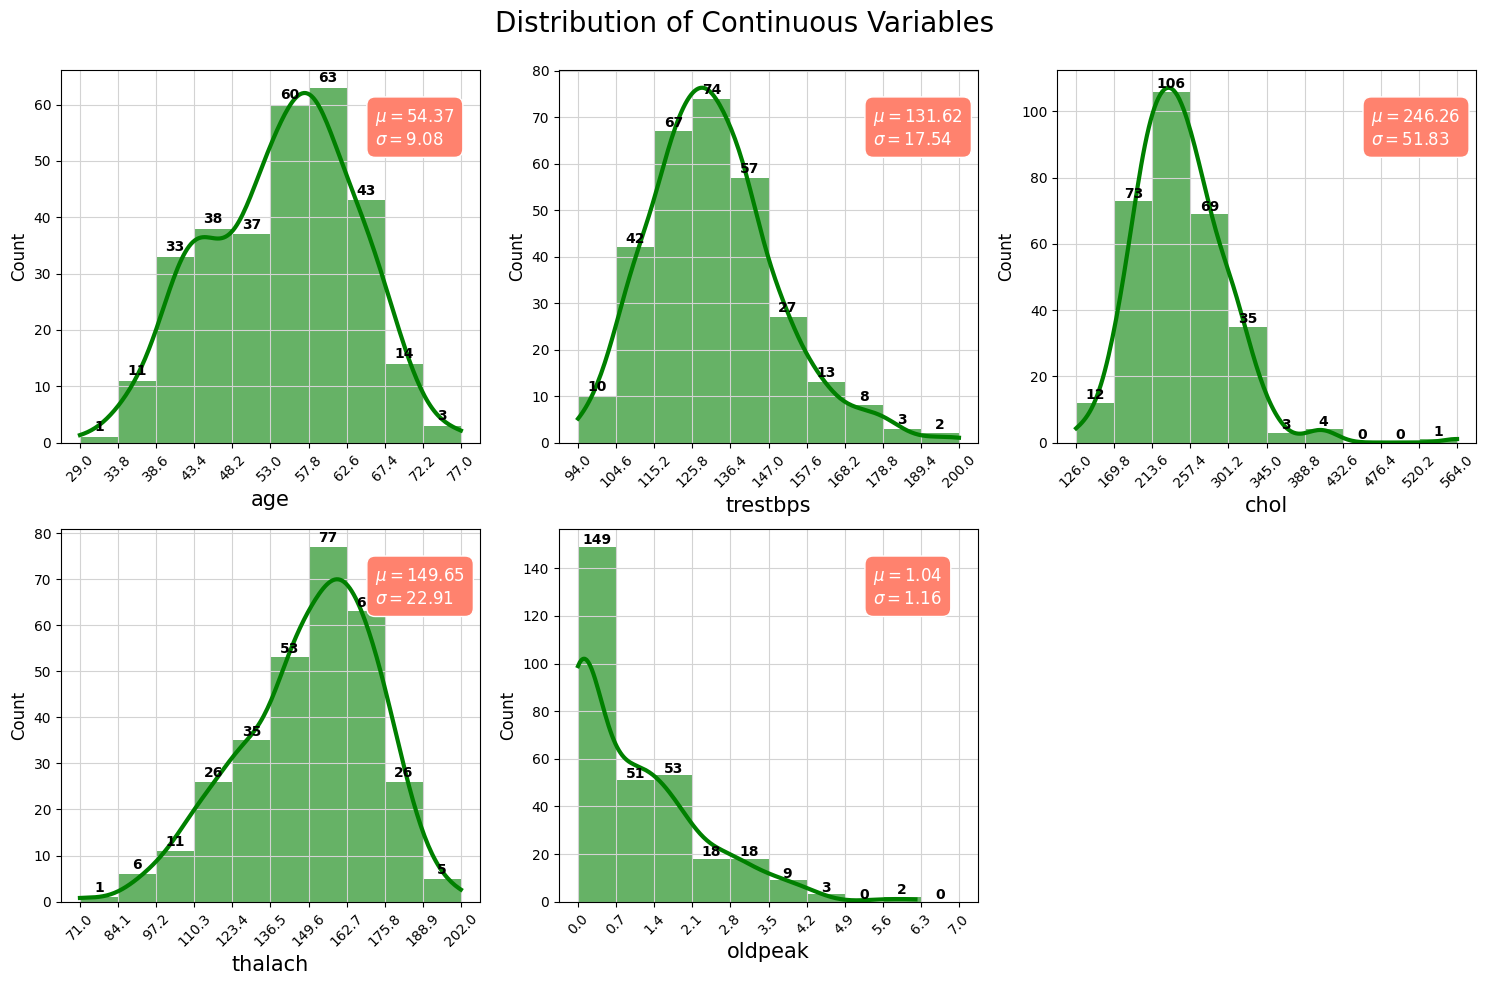

In [51]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_fetures]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='green', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

Inferences:
- Age (age): The distribution is somewhat uniform, but there's a peak around the late 50s. The mean age is approximately 54.37 years with a standard deviation of 9.08 years.
- Resting Blood Pressure (trestbps): The resting blood pressure for most individuals is concentrated around 120-140 mm Hg, with a mean of approximately 131.62 mm Hg and a standard deviation of 17.54 mm Hg.
- Serum Cholesterol (chol): Most individuals have cholesterol levels between 200 and 300 mg/dl. The mean cholesterol level is around 246.26 mg/dl with a standard deviation of 51.83 mg/dl.
- Maximum Heart Rate Achieved (thalach): The majority of the individuals achieve a heart rate between 140 and 170 bpm during a stress test. The mean heart rate achieved is approximately 149.65 bpm with a standard deviation of 22.91 bpm.
- ST Depression Induced by Exercise (oldpeak): Most of the values are concentrated towards 0, indicating that many individuals did not experience significant ST depression during exercise. The mean ST depression value is 1.04 with a standard deviation of 1.16.
------
> Upon reviewing the histograms of the continuous features and cross-referencing them with the provided feature descriptions, everything appears consistent and within expected ranges. There doesn't seem to be any noticeable noise or implausible values among the continuous variables.

##### 4.1.2 Categorical Variable Univariate Analysis

In [52]:
# filter out categorical features from the univariate analysis
categorical_features = df.columns.difference(continuous_fetures)
df_categorical = df[categorical_features]

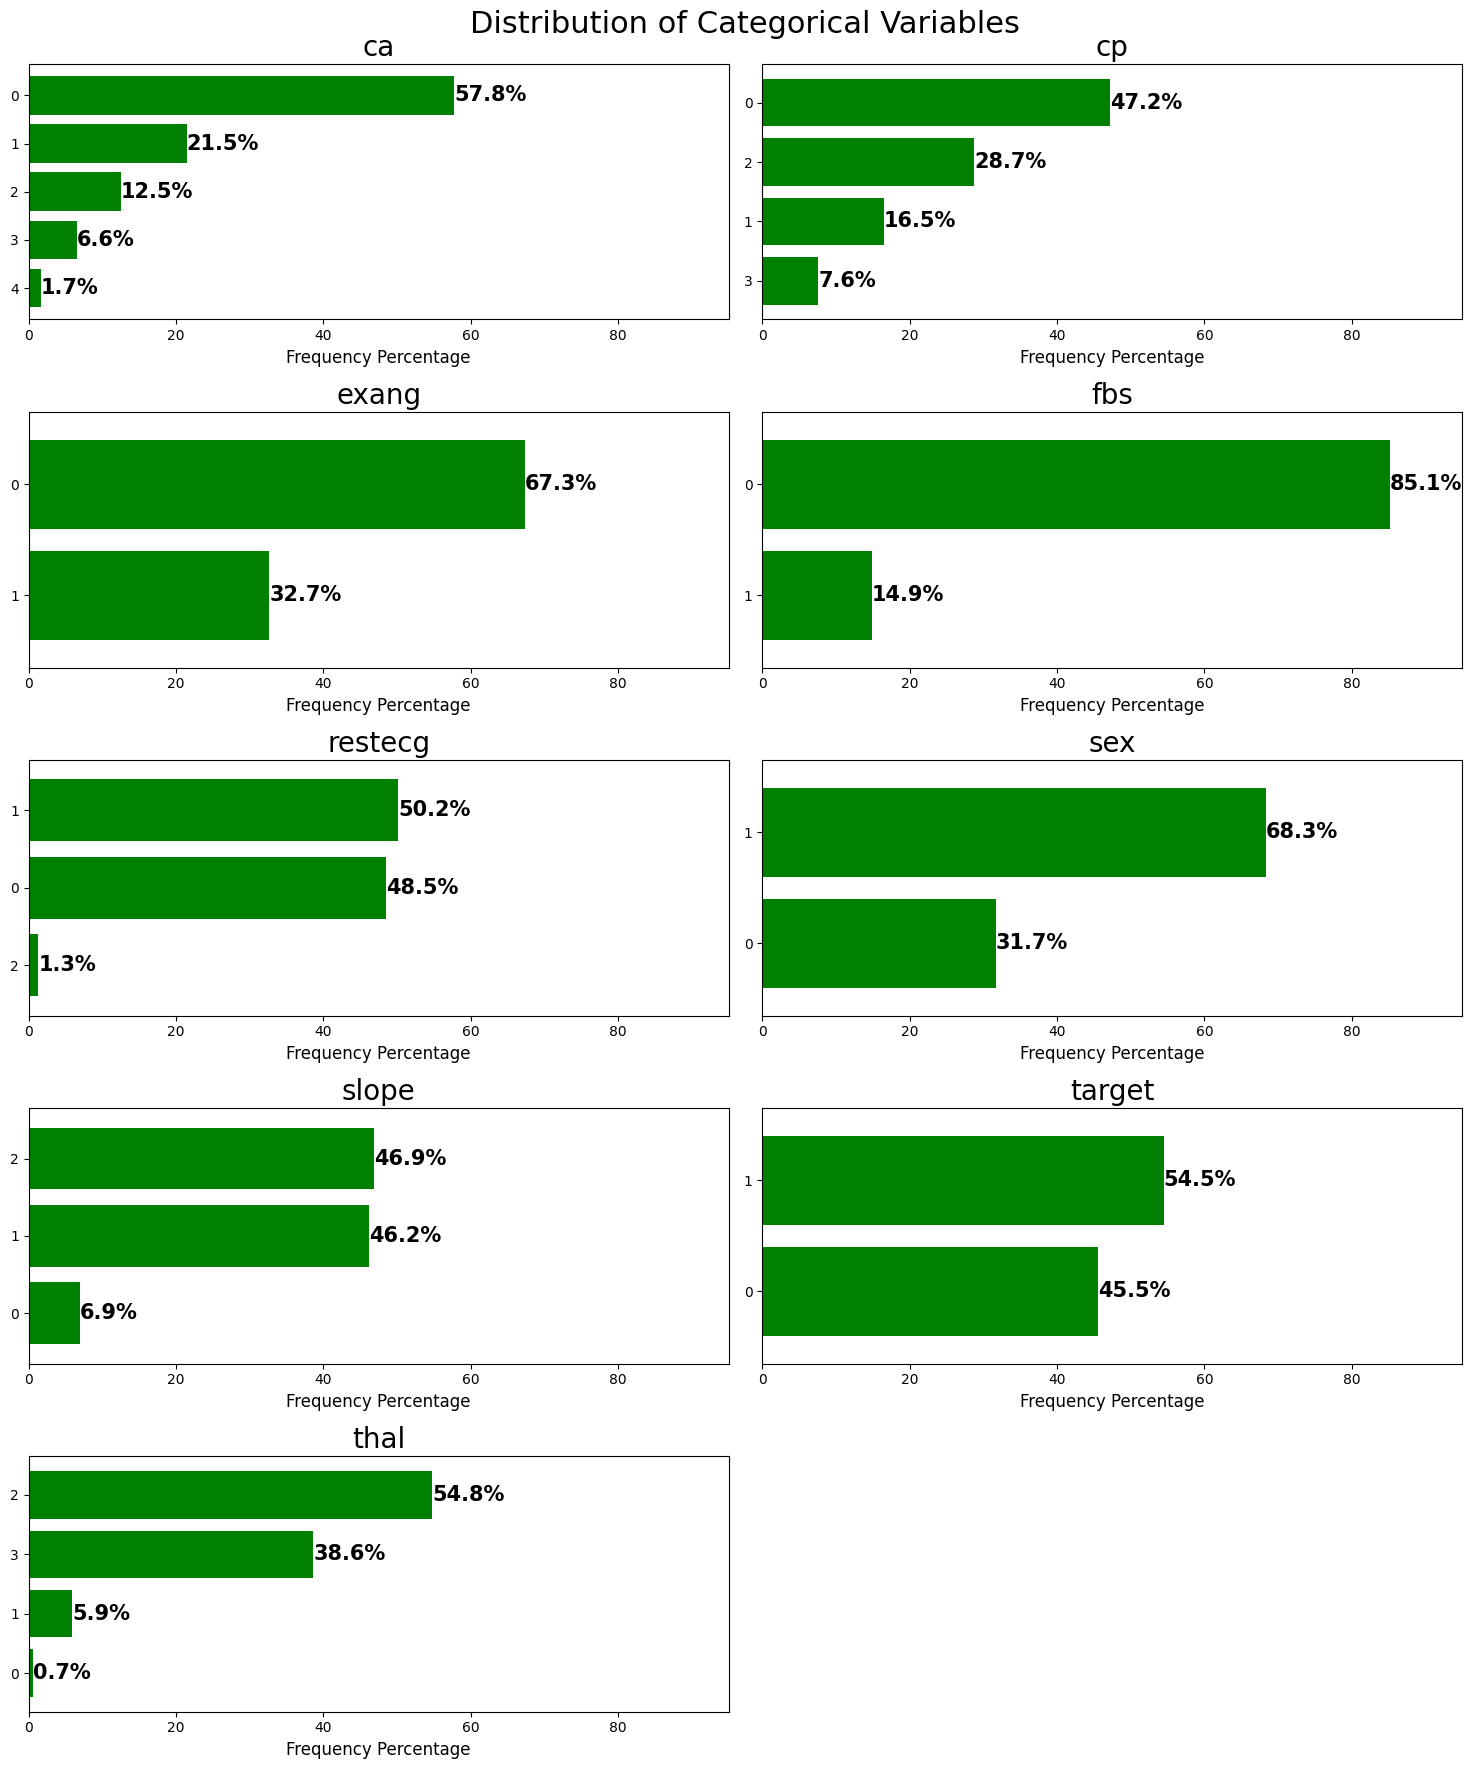

In [53]:
# set up the subplotfor 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# loop to plot bar charts for each bar feature in the 4x2 layout
for i, col in enumerate(categorical_features):
  row = i // 2
  col_idx = i % 2

  # calculate frequency percentage
  value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()

  # plot bar charts
  value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='green')

  # Add frequency percentages to the bars
  for index, value in enumerate(value_counts):
      ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
  
  ax[row, col_idx].set_xlim([0, 95])
  ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
  ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Inferences:
- Gender (sex): The dataset is predominantly female, constituting a significant majority.
- Type of Chest Pain (cp): The dataset shows varied chest pain types among patients. Type 0 (Typical angina) seems to be the most prevalent, but an exact distribution among the types can be inferred from the bar plots.
- Fasting Blood Sugar (fbs): A significant majority of the patients have their fasting blood sugar level below 120 mg/dl, indicating that high blood sugar is not a common condition in this dataset.
- Resting Electrocardiographic Results (restecg): The results show varied resting electrocardiographic outcomes, with certain types being more common than others. The exact distribution can be gauged from the plots.
- Exercise-Induced Angina (exang): A majority of the patients do not experience exercise-induced angina, suggesting that it might not be a common symptom among the patients in this dataset.
- Slope of the Peak Exercise ST Segment (slope): The dataset shows different slopes of the peak exercise ST segment. A specific type might be more common, and its distribution can be inferred from the bar plots.
- Number of Major Vessels Colored by Fluoroscopy (ca): Most patients have fewer major vessels colored by fluoroscopy, with '0' being the most frequent.
- Thalium Stress Test Result (thal): The dataset displays a variety of thalium stress test results. One particular type seems to be more prevalent, but the exact distribution can be seen in the plots.
- Presence of Heart Disease (target): The dataset is nearly balanced in terms of heart disease presence, with about 54.5% having it and 45.5% not having it.

### 4.2 Bicariate Analysis

For our bivariate analysis on the dataset's fetures with respoect to the target variable:
- For continous data: We are going to use bar plots to showcase the average of each feature for the different target classes, and KDE plots to understand the distribution of each features across the target classes. This adis in discerning how each features varies between the two target outcomes.
- for categorical data: I am going to employ 100% stacked bar plots to depick the proportion of each category across the target classes. This offers a comprehensive view of how different categories within a features relate to the target.

Through these visualization techniques, we are going vto gain a deeper understanding of the relationship between individual features and the target, revelaing potential predictord for heart disease.

##### 4.2.1 Numericla Features vs Target

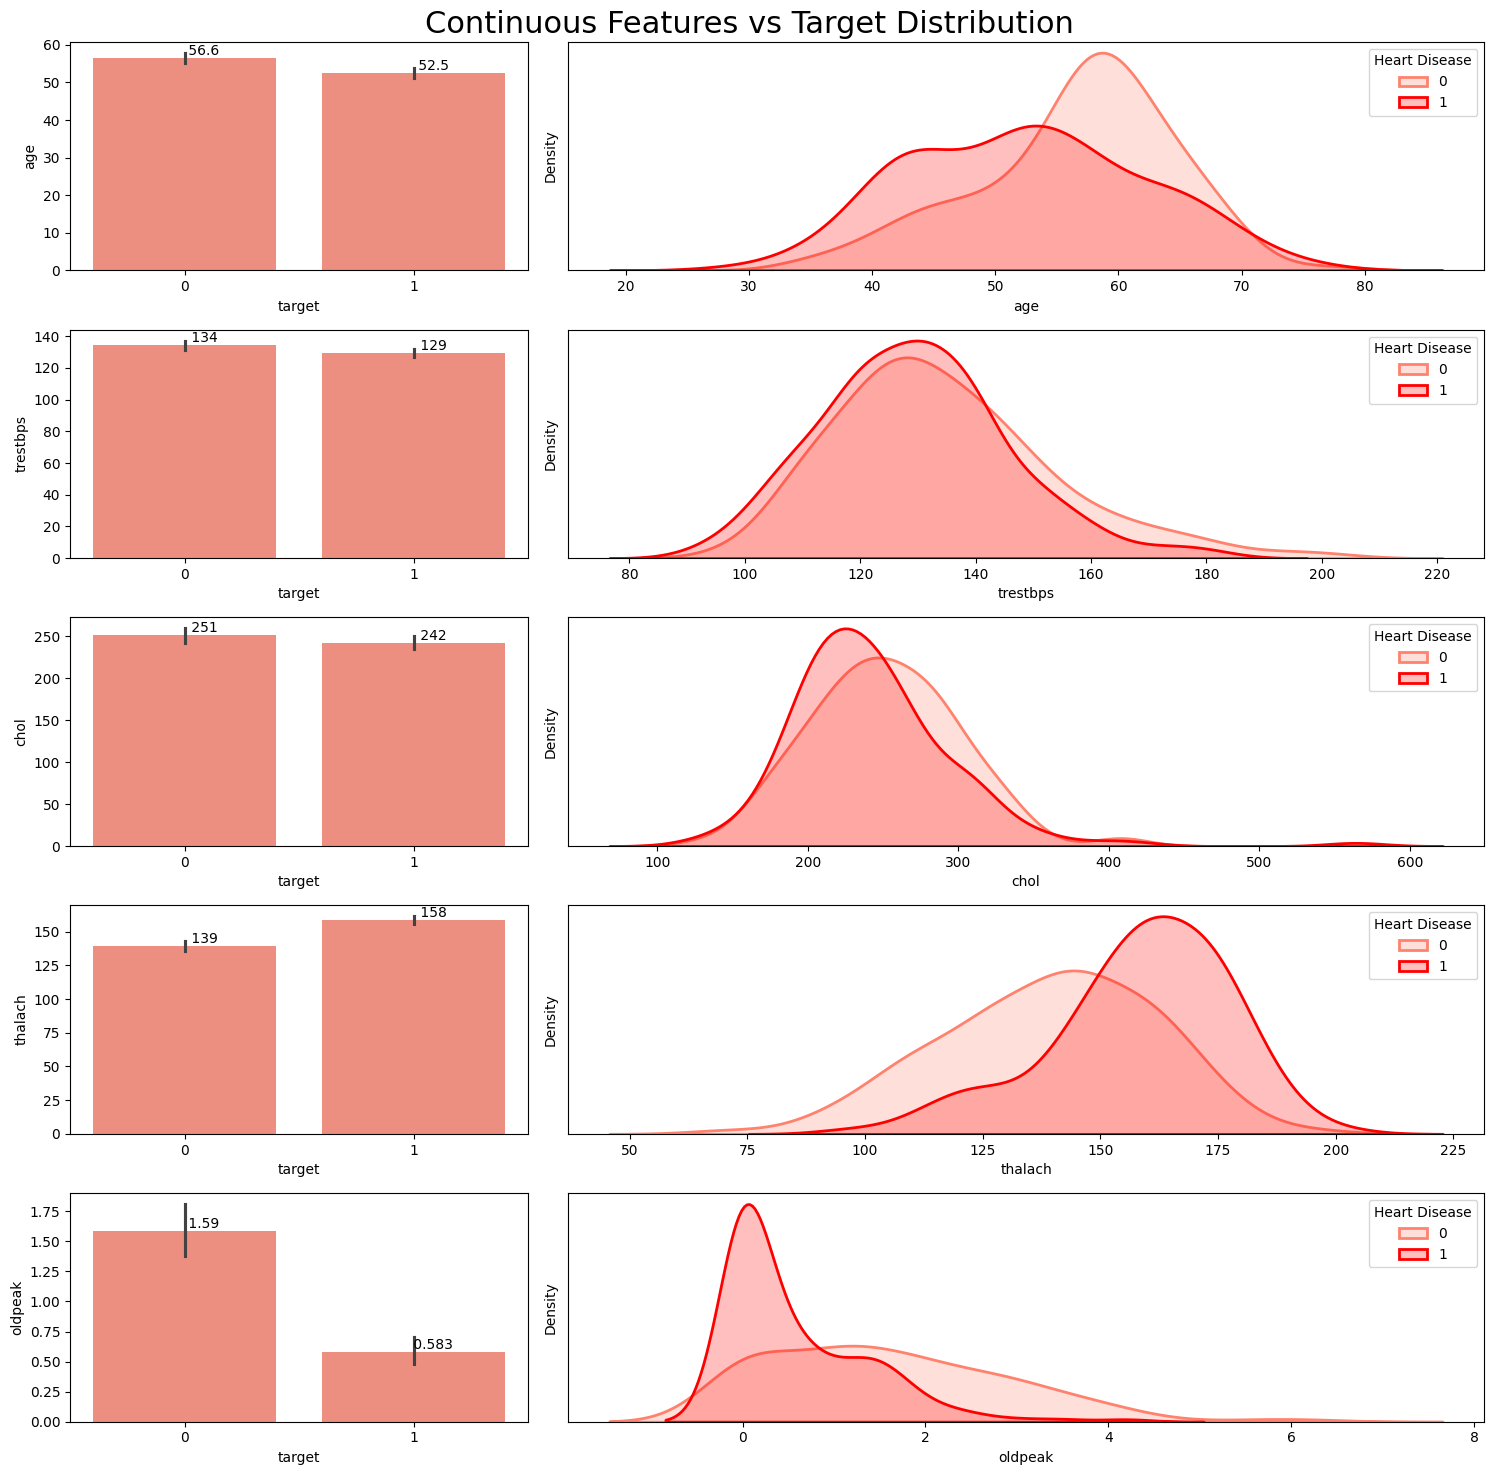

In [54]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_fetures), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_fetures):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

##### 4.2.2 Categorical Features vs Target

In [55]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

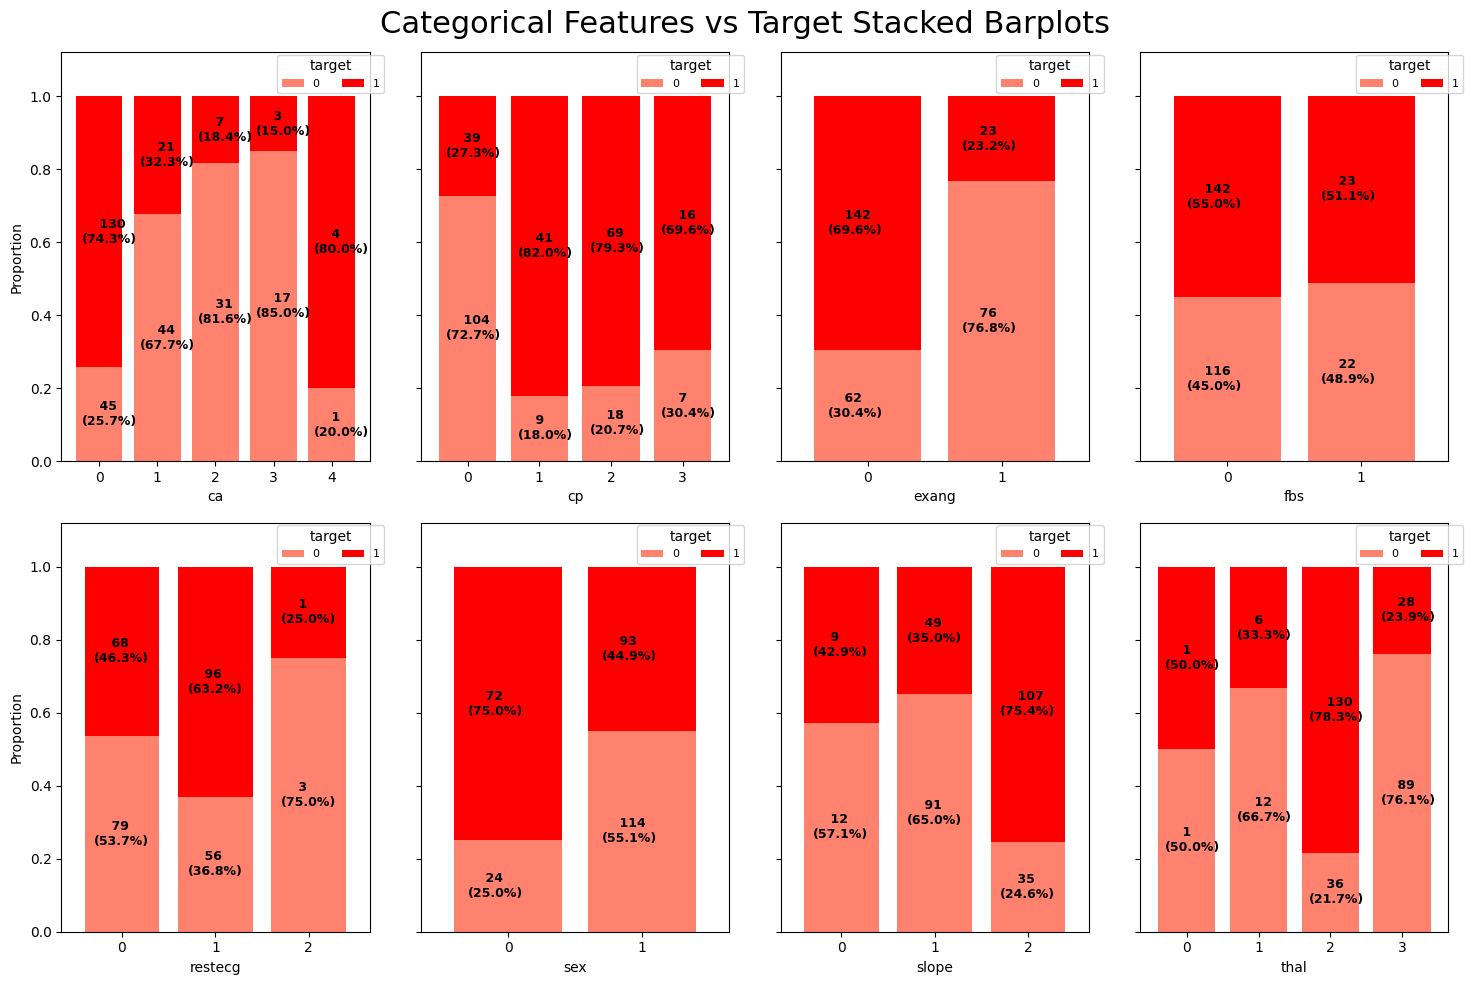

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

## 5 - Data Processing

### 5.1 Irrelevant Features Removal

All features in the dataset appear to be relevant based on our EDA. No columns seem redundant or irrelevant. Thus, we'll retain all features, ansuring no valuable information is lost, especially given the dataset's small size.

### Missing Value Treatment

In [57]:
# check for missing values in the dataset
df.isnull().sum().sum()

0

After inspections, it is obvious that there are no missing value in our dataset This ideal as it means we don't have to make decisions about imputation or removal, which can introduce bias or reduce our already limited dataset size.

### 5.3 Outlier Treatment

In [58]:
continuous_fetures

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [59]:
Q1 = df[continuous_fetures].quantile(0.25)
Q3 = df[continuous_fetures].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_fetures] < (Q1 - 1.5 * IQR)) | (df[continuous_fetures] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

### 5.4 Categorical Features Encoding

In [60]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1           uint8
cp_2           uint8
cp_3           uint8
restecg_1      uint8
restecg_2      uint8
thal_1         uint8
thal_2         uint8
thal_3         uint8
dtype: object

In [61]:
# displaying the resulting data frame after one-hot encoding
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0


### 5.5 Feature Scalling

While feature scaling is vital for some models, not all algorithm require scaled data. For instance, Decision Tree-based models are scale-invariant. Given our intent to use a mix of models (some requiring scaling, others not). We have chosen to handle scaling later using pipelines. This approach lets us apply scaling specifically for models that benefirt from it, ensuring flexibility and efficiency in out modelling process.

### 5.6 Transformring Skewed Features

In [62]:
# define the features (X) and the output lables (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [63]:
# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
continuous_fetures

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [65]:
# adding a small constant to 'oldpeak' to make all values positive
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

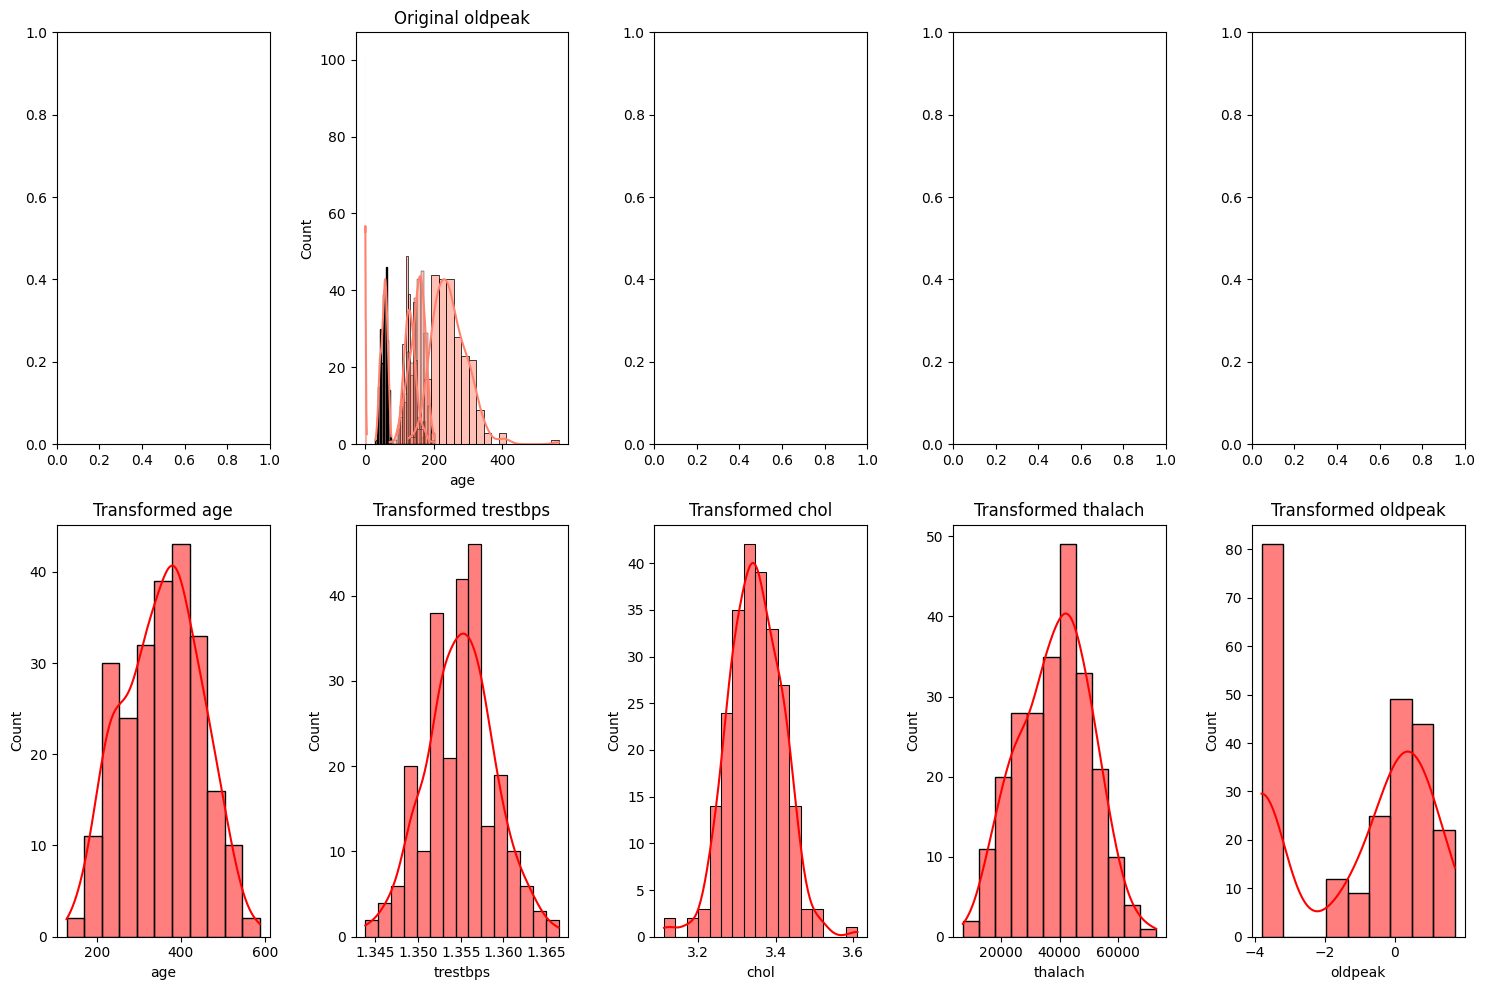

In [66]:
# checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# original distributitions
for i, col in enumerate(continuous_fetures):
  sns.histplot(X_train[col], kde=True, ax=ax[0, 1], color='#ff826e').set_title(f'Original {col}')


# applying Box-Cox transformation
# dictionary to store lambda values for each feature
lambdas = {}

for i, col in enumerate(continuous_fetures):
  # only apply box-cox for positive values
  if X_train[col].min() > 0:
    X_train[col], lambdas[col] = boxcox(X_train[col])
    # Applying the same lambda to test data
    X_test[col] = boxcox(X_test[col], lmbda=lambdas[col]) 
    sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'Transformed {col}')
  else:
      sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()
    

In [67]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
268,342.754898,1,1.353059,3.402942,0,20820.009767,1,1.304943,1,2,0,0,0,0,0,0,1,0
126,275.190069,1,1.350221,3.288877,0,33435.269129,0,-1.851381,2,0,0,0,0,1,0,0,1,0
25,528.260118,0,1.360992,3.420616,0,44345.652981,0,-0.837514,2,2,1,0,0,1,0,0,1,0
213,415.588619,0,1.358288,3.425910,0,35044.223103,1,0.001000,1,0,0,0,0,0,0,0,0,1
2,221.711145,0,1.355058,3.288877,0,50785.314539,0,0.348437,2,0,1,0,0,0,0,0,1,0


## 6 - Decision Tree Model Building

### 6.1 DT Base Model Definitions

In [68]:
dt_base = DecisionTreeClassifier(random_state=0)

### 6.2 DT Hyperparameter Tuning

In [69]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [70]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [71]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [72]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


### 6.3 DT Model Evaluation

In [73]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       107
           1       0.80      0.93      0.86       135

    accuracy                           0.83       242
   macro avg       0.85      0.82      0.83       242
weighted avg       0.84      0.83      0.83       242



In [74]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.65      0.75        31
           1       0.72      0.93      0.81        30

    accuracy                           0.79        61
   macro avg       0.81      0.79      0.78        61
weighted avg       0.82      0.79      0.78        61



In [75]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

In [76]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.91,0.72,0.65,0.93,0.75,0.81,0.81,0.79,0.78,0.79


In [77]:
joblib.dump(best_dt, 'dt_model.joblib')

['dt_model.joblib']